#### Base Settings

##### 데이터 출처
- [무료 레시피 데이터](https://kadx.co.kr/product/detail/0c5ec800-4fc2-11eb-8b6e-e776ccea3964)



##### Library

In [1]:
# Library import

## pandas
import pandas as pd

import nltk

import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf


import tensorflow_datasets as tfds

### Data Preprocessing

#### Read

In [2]:
google_url = "https://drive.google.com/file/d/1j_cOLBGq2zW2saTFa6kv4oBCjsVQ9JfU/view?usp=sharing"
file_url = "https://drive.google.com/uc?id=" + google_url.split('/')[-2]
df_raw = pd.read_csv(file_url, encoding='cp949')
df_raw.head()

,RCP_SNO,RCP_TTL,CKG_NM,RGTR_ID,RGTR_NM,INQ_CNT,RCMM_CNT,SRAP_CNT,CKG_MTH_ACTO_NM,CKG_STA_ACTO_NM,CKG_MTRL_ACTO_NM,CKG_KND_ACTO_NM,CKG_IPDC,CKG_MTRL_CN,CKG_INBUN_NM,CKG_DODF_NM,CKG_TIME_NM,FIRST_REG_DT
0,128671,어묵김말이,어묵김말이,skfo0701,꽃날,9592,6,66,튀김,간식,가공식품류,디저트,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,[재료] 어묵 2개| 김밥용김 3장| 당면 1움큼| 양파 1/2개| 당근 1/2개|...,2인분,초급,60분이내,20070402131403
1,128892,두부에 꼬리가 달렸어요!!,NaN,skfo0701,꽃날,5538,3,26,부침,일상,해물류,밑반찬,꼬리가 너-무- 매력적인 두부새우전. 두부와 야채를 한번에!! 영양까지 만점인 두부...,[재료] 두부 1/2모| 당근 1/2개| 고추 2개| 브로콜리 1/4개| 새우 4마...,3인분,초급,30분이내,20070402205937
2,128932,입안에서 톡톡톡,NaN,skfo0701,꽃날,6802,8,36,굽기,일상,해물류,밥/죽/떡,간단하게 만들어 보는 알이 톡톡톡 알밥♥ 다 먹고 누룽지까지 싹싹 긁어먹는게 최고죠...,[재료] 밥 1+1/2공기| 당근 1/4개| 치자단무지 1/2개| 신김치 1쪽| 무...,2인분,초급,30분이내,20070402224355
3,131871,★현미호두죽,현미호두죽,cds1117,햇님&별님,2912,0,9,끓이기,일상,쌀,밥/죽/떡,현미호두죽,[재료] 현미 4컵| 찹쌀 2컵| 호두 50g| 물 1/2컵| 소금 약간,2인분,초급,30분이내,20070410142301
4,139247,부들부들 보들보들 북어갈비♥,북어갈비,skfo0701,꽃날,6865,3,97,굽기,술안주,건어물류,메인반찬,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,[재료] 북어포 1마리| 찹쌀가루 1C [양념] 간장 2T| 설탕 1T| 물 1T|...,2인분,초급,60분이내,20070501000844


In [3]:
col_name_eng = list(df_raw.columns)
col_name_kor = ["레시피일련번호", "레시피제목", "요리명", "등록자ID", "등록자명", "조회수", "추천수", "스크랩수", "요리방법별명", "요리상황별명", "요리재료별명", "요리종류별명", "요리소개", "요리재료내용", "요리인분명", "요리난이도명", "요리시간명", "최초등록일시"]
df_kor = df_raw.copy()
df_kor.columns = col_name_kor
df_kor.head()

,레시피일련번호,레시피제목,요리명,등록자ID,등록자명,조회수,추천수,스크랩수,요리방법별명,요리상황별명,요리재료별명,요리종류별명,요리소개,요리재료내용,요리인분명,요리난이도명,요리시간명,최초등록일시
0,128671,어묵김말이,어묵김말이,skfo0701,꽃날,9592,6,66,튀김,간식,가공식품류,디저트,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,[재료] 어묵 2개| 김밥용김 3장| 당면 1움큼| 양파 1/2개| 당근 1/2개|...,2인분,초급,60분이내,20070402131403
1,128892,두부에 꼬리가 달렸어요!!,NaN,skfo0701,꽃날,5538,3,26,부침,일상,해물류,밑반찬,꼬리가 너-무- 매력적인 두부새우전. 두부와 야채를 한번에!! 영양까지 만점인 두부...,[재료] 두부 1/2모| 당근 1/2개| 고추 2개| 브로콜리 1/4개| 새우 4마...,3인분,초급,30분이내,20070402205937
2,128932,입안에서 톡톡톡,NaN,skfo0701,꽃날,6802,8,36,굽기,일상,해물류,밥/죽/떡,간단하게 만들어 보는 알이 톡톡톡 알밥♥ 다 먹고 누룽지까지 싹싹 긁어먹는게 최고죠...,[재료] 밥 1+1/2공기| 당근 1/4개| 치자단무지 1/2개| 신김치 1쪽| 무...,2인분,초급,30분이내,20070402224355
3,131871,★현미호두죽,현미호두죽,cds1117,햇님&별님,2912,0,9,끓이기,일상,쌀,밥/죽/떡,현미호두죽,[재료] 현미 4컵| 찹쌀 2컵| 호두 50g| 물 1/2컵| 소금 약간,2인분,초급,30분이내,20070410142301
4,139247,부들부들 보들보들 북어갈비♥,북어갈비,skfo0701,꽃날,6865,3,97,굽기,술안주,건어물류,메인반찬,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,[재료] 북어포 1마리| 찹쌀가루 1C [양념] 간장 2T| 설탕 1T| 물 1T|...,2인분,초급,60분이내,20070501000844


In [4]:
df_kor.shape

(128400, 18)

In [5]:
df = df_kor[['요리명','요리소개','요리재료내용']].copy()
df.shape

(128400, 3)

In [6]:
df.isna().sum()

요리명       2090
요리소개       617
요리재료내용    1060
dtype: int64

In [7]:
df.dropna(axis='index', how='any', inplace=True)
df.reset_index(drop=True)
df.shape

(124921, 3)

In [8]:
df.head()

,요리명,요리소개,요리재료내용
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,[재료] 어묵 2개| 김밥용김 3장| 당면 1움큼| 양파 1/2개| 당근 1/2개|...
3,현미호두죽,현미호두죽,[재료] 현미 4컵| 찹쌀 2컵| 호두 50g| 물 1/2컵| 소금 약간
4,북어갈비,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,[재료] 북어포 1마리| 찹쌀가루 1C [양념] 간장 2T| 설탕 1T| 물 1T|...
5,토마토스파게티,한번 만들어 두면 이모저모 쓸 용도가 많은 토마토소스를 이용한 토마토 스파게티.,[재료] 파스타면 [양념] 토마토 1개| 토마토 페이스트 3T| 양파 1/2개| 다...
6,표고버섯탕수,탕수육 먹을때 칼로리때문에 걱정하시는 분들!! 이제는 걱걱걱 정하지 마세요~ 칼로리...,[재료] 건표고버섯 9개| 오이 1/2개| 당근 1/2개| 양파 1/2개| 사과 1...


In [9]:
df["재료1"] = df["요리재료내용"].str.split("[양념]").str[0]

In [10]:
df.isna().sum()

요리명       0
요리소개      0
요리재료내용    0
재료1       0
dtype: int64

In [11]:
df["재료2"] = df["재료1"].str.replace(pat=r'[^ㄱ-ㅣ가-힣]', repl=r';', regex=True)
df["재료2"] = df["재료2"].str.replace(pat=r'[재료]', repl=r'', regex=True)

In [12]:
df.head()

,요리명,요리소개,요리재료내용,재료1,재료2
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,[재료] 어묵 2개| 김밥용김 3장| 당면 1움큼| 양파 1/2개| 당근 1/2개|...,[재료] 어묵 2개| 김밥용김 3장| 당면 1움큼|,;;;어묵;;개;;김밥용김;;장;;당면;;움큼;;
3,현미호두죽,현미호두죽,[재료] 현미 4컵| 찹쌀 2컵| 호두 50g| 물 1/2컵| 소금 약간,[재료] 현미 4컵| 찹쌀 2컵| 호두 50g| 물 1/2컵| 소금 약간,;;;현미;;컵;;찹쌀;;컵;;호두;;;;;;물;;;;컵;;소금;약간
4,북어갈비,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,[재료] 북어포 1마리| 찹쌀가루 1C [양념] 간장 2T| 설탕 1T| 물 1T|...,[재료] 북어포 1마리| 찹쌀가루 1C [,;;;북어포;;마리;;찹쌀가루;;;;;
5,토마토스파게티,한번 만들어 두면 이모저모 쓸 용도가 많은 토마토소스를 이용한 토마토 스파게티.,[재료] 파스타면 [양념] 토마토 1개| 토마토 페이스트 3T| 양파 1/2개| 다...,[재료] 파스타면 [,;;;파스타면;;
6,표고버섯탕수,탕수육 먹을때 칼로리때문에 걱정하시는 분들!! 이제는 걱걱걱 정하지 마세요~ 칼로리...,[재료] 건표고버섯 9개| 오이 1/2개| 당근 1/2개| 양파 1/2개| 사과 1...,[재료] 건표고버섯 9개| 오이 1/2개| 당근 1/2개|,;;;건표고버섯;;개;;오이;;;;개;;당근;;;;개;;


In [13]:
df["tokens"] = df["재료2"].apply(lambda x: x.split(";"))
df.drop(columns=['요리재료내용', '재료1', '재료2'], inplace=True)

In [14]:
df.head()

,요리명,요리소개,tokens
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,"[, , , 어묵, , 개, , 김밥용김, , 장, , 당면, , 움큼, , ]"
3,현미호두죽,현미호두죽,"[, , , 현미, , 컵, , 찹쌀, , 컵, , 호두, , , , , , 물, ..."
4,북어갈비,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,"[, , , 북어포, , 마리, , 찹쌀가루, , , , , ]"
5,토마토스파게티,한번 만들어 두면 이모저모 쓸 용도가 많은 토마토소스를 이용한 토마토 스파게티.,"[, , , 파스타면, , ]"
6,표고버섯탕수,탕수육 먹을때 칼로리때문에 걱정하시는 분들!! 이제는 걱걱걱 정하지 마세요~ 칼로리...,"[, , , 건표고버섯, , 개, , 오이, , , , 개, , 당근, , , , ..."


In [15]:
word_counts = Counter()
df['tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('', 2122584),
 ('개', 87958),
 ('큰술', 35550),
 ('컵', 24245),
 ('약간', 21952),
 ('소금', 18720),
 ('설탕', 16697),
 ('장', 16242),
 ('물', 14424),
 ('대파', 12849)]

In [16]:
# def stop_word(row_list):
#     for i in row_list:
#         if (i == "") or (i == " ") or (i == "개") or (i == "큰술") or (i == "컵") \
#             or (i == "약간") or (i == "소금") or (i == "설탕") or (i == "장") or (i == "물") \
#             or (i == "줌") or (i == "스푼") or (i == "마리") or (i == "적당량") or (i == "조금") \
#             or (i == "숟가락") or (i == "작은술") or (i == "청") or (i == "대") or (i == "공기") \
#             or (i == "모") or (i == "봉지") or (i == "다진") or (i == "인분") or (i == "필수") \
#             or (i == "팩") or (i == "종이컵") or (i == "쪽") or (i == "꼬집") or (i == "그램") \
#             or (i == "알") or (i == "줄") or (i == "조각") or (i == "단") or (i == "뿌리") or (i == "캔"):
#                 row_list.remove(i)
#     return row_list

In [17]:
# def stop_word(row_list):
#     for i in row_list:
#         if (i == "") or (i == " ") or (i == "개"):
#             row_list.remove(i)
#     return row_list

In [18]:
def stop_word(row_list):
    stop_words = {""," ","개","큰술","컵","약간","소금","설탕","장","물","줌","스푼","마리","적당량","조금","숟가락","작은술","청","대"\
                  ,"공기","모","봉지","다진","인분","필수","팩","종이컵","쪽","꼬집","그램","알","줄","조각","단","뿌리","캔","움큼"}
                  
    clean_token = [x for x in row_list if x not in stop_words]
    return clean_token

In [19]:
df['clean_tok'] = df['tokens'].apply(stop_word)
df.head()

,요리명,요리소개,tokens,clean_tok
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,"[, , , 어묵, , 개, , 김밥용김, , 장, , 당면, , 움큼, , ]","[어묵, 김밥용김, 당면]"
3,현미호두죽,현미호두죽,"[, , , 현미, , 컵, , 찹쌀, , 컵, , 호두, , , , , , 물, ...","[현미, 찹쌀, 호두]"
4,북어갈비,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,"[, , , 북어포, , 마리, , 찹쌀가루, , , , , ]","[북어포, 찹쌀가루]"
5,토마토스파게티,한번 만들어 두면 이모저모 쓸 용도가 많은 토마토소스를 이용한 토마토 스파게티.,"[, , , 파스타면, , ]",[파스타면]
6,표고버섯탕수,탕수육 먹을때 칼로리때문에 걱정하시는 분들!! 이제는 걱걱걱 정하지 마세요~ 칼로리...,"[, , , 건표고버섯, , 개, , 오이, , , , 개, , 당근, , , , ...","[건표고버섯, 오이, 당근]"


In [20]:
word_counts = Counter()
df['clean_tok'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('대파', 12849),
 ('계란', 11772),
 ('달걀', 9502),
 ('당근', 8408),
 ('참기름', 7840),
 ('버터', 7731),
 ('우유', 7218),
 ('감자', 7023),
 ('마늘', 7016),
 ('다진마늘', 6441)]

In [21]:
df['food'] = df["clean_tok"].apply(lambda x: " ".join(x))
df.head()

,요리명,요리소개,tokens,clean_tok,food
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,"[, , , 어묵, , 개, , 김밥용김, , 장, , 당면, , 움큼, , ]","[어묵, 김밥용김, 당면]",어묵 김밥용김 당면
3,현미호두죽,현미호두죽,"[, , , 현미, , 컵, , 찹쌀, , 컵, , 호두, , , , , , 물, ...","[현미, 찹쌀, 호두]",현미 찹쌀 호두
4,북어갈비,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,"[, , , 북어포, , 마리, , 찹쌀가루, , , , , ]","[북어포, 찹쌀가루]",북어포 찹쌀가루
5,토마토스파게티,한번 만들어 두면 이모저모 쓸 용도가 많은 토마토소스를 이용한 토마토 스파게티.,"[, , , 파스타면, , ]",[파스타면],파스타면
6,표고버섯탕수,탕수육 먹을때 칼로리때문에 걱정하시는 분들!! 이제는 걱걱걱 정하지 마세요~ 칼로리...,"[, , , 건표고버섯, , 개, , 오이, , , , 개, , 당근, , , , ...","[건표고버섯, 오이, 당근]",건표고버섯 오이 당근


### Modeling

In [22]:
count_vec = CountVectorizer()
count_vec_matrix = count_vec.fit_transform(df['food'])

In [23]:
print(count_vec_matrix.shape)
print(count_vec_matrix[0])
# print(count_vec_matrix)

(124921, 29772)
  (0, 18411)	1
  (0, 3070)	1
  (0, 5822)	1


In [24]:
tfidf_vec = TfidfVectorizer()
tfidf_vec_matrix = tfidf_vec.fit_transform(df['food'])

In [25]:
print(tfidf_vec_matrix.shape)
print(tfidf_vec_matrix[0])
# print(tfidf_vec_vec_matrix)

(124921, 29772)
  (0, 5822)	0.5443668633927925
  (0, 3070)	0.6820509666237706
  (0, 18411)	0.488335127722216


In [26]:
tfidf_vec_df = pd.DataFrame(tfidf_vec_matrix.todense(), columns=tfidf_vec.get_feature_names_out())

In [27]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(tfidf_vec_matrix)

NearestNeighbors()

In [28]:
k_neighbors = nn.kneighbors([tfidf_vec_df.iloc[0]])
list(k_neighbors[1][0])

[0, 103078, 68604, 46051, 102790]

In [29]:
df.iloc[list(k_neighbors[1][0]),:]

,요리명,요리소개,tokens,clean_tok,food
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,"[, , , 어묵, , 개, , 김밥용김, , 장, , 당면, , 움큼, , ]","[어묵, 김밥용김, 당면]",어묵 김밥용김 당면
106271,어묵당면볶음,쉽고 간단하게~ 당면볶음,"[, , , 당면, , 줌, , 어묵, , 장, , ]","[당면, 어묵]",당면 어묵
71497,어묵당면덮밥,좋아하는 재료만 골라 취향저격 스타일로 만들어 본 매콤어묵당면덮밥입니다:),"[, , , 밥, , 공기, , 당면, , 줌, , 어묵, , 장, , ]","[밥, 당면, 어묵]",밥 당면 어묵
48375,당면볶이,출출한 밤 냉장고속엔 암것도 없고 라면도 없고 이럴땐 라볶이보다 더 맛있는 당...,"[, , , 당면, , 줌, , 대파, , 뿌리, , 어묵, , 장, , 물, 적당...","[당면, 대파, 어묵]",당면 대파 어묵
105981,배추잡채,집에 배추가 많은데..어떻게 해먹을까 하다가 오랜만에 잡채는 먹고싶고 해서 배추를 ...,"[, , , 당면, , 줌, , 어묵, , 장, , 당근, , 개, , ]","[당면, 어묵, 당근]",당면 어묵 당근


In [30]:
df.columns = ["A","desc","tokens","clean_tok","Q"]
df.head()

,A,desc,tokens,clean_tok,Q
0,어묵김말이,맛있는 김말이에 쫄깃함을 더한 어묵 김말이예요-,"[, , , 어묵, , 개, , 김밥용김, , 장, , 당면, , 움큼, , ]","[어묵, 김밥용김, 당면]",어묵 김밥용김 당면
3,현미호두죽,현미호두죽,"[, , , 현미, , 컵, , 찹쌀, , 컵, , 호두, , , , , , 물, ...","[현미, 찹쌀, 호두]",현미 찹쌀 호두
4,북어갈비,오늘은 집에서 굴러다니고 쉽게 구할 수 있는 북어로 일품요리를 만들어 보았어요! 도...,"[, , , 북어포, , 마리, , 찹쌀가루, , , , , ]","[북어포, 찹쌀가루]",북어포 찹쌀가루
5,토마토스파게티,한번 만들어 두면 이모저모 쓸 용도가 많은 토마토소스를 이용한 토마토 스파게티.,"[, , , 파스타면, , ]",[파스타면],파스타면
6,표고버섯탕수,탕수육 먹을때 칼로리때문에 걱정하시는 분들!! 이제는 걱걱걱 정하지 마세요~ 칼로리...,"[, , , 건표고버섯, , 개, , 오이, , , , 개, , 당근, , , , ...","[건표고버섯, 오이, 당근]",건표고버섯 오이 당근


In [31]:
train_data = df.copy()

### Model Function

In [32]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


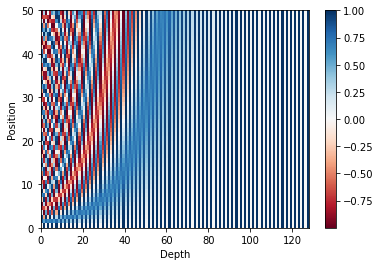

In [33]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [34]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [35]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [36]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [37]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [38]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [39]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [40]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [41]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [42]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


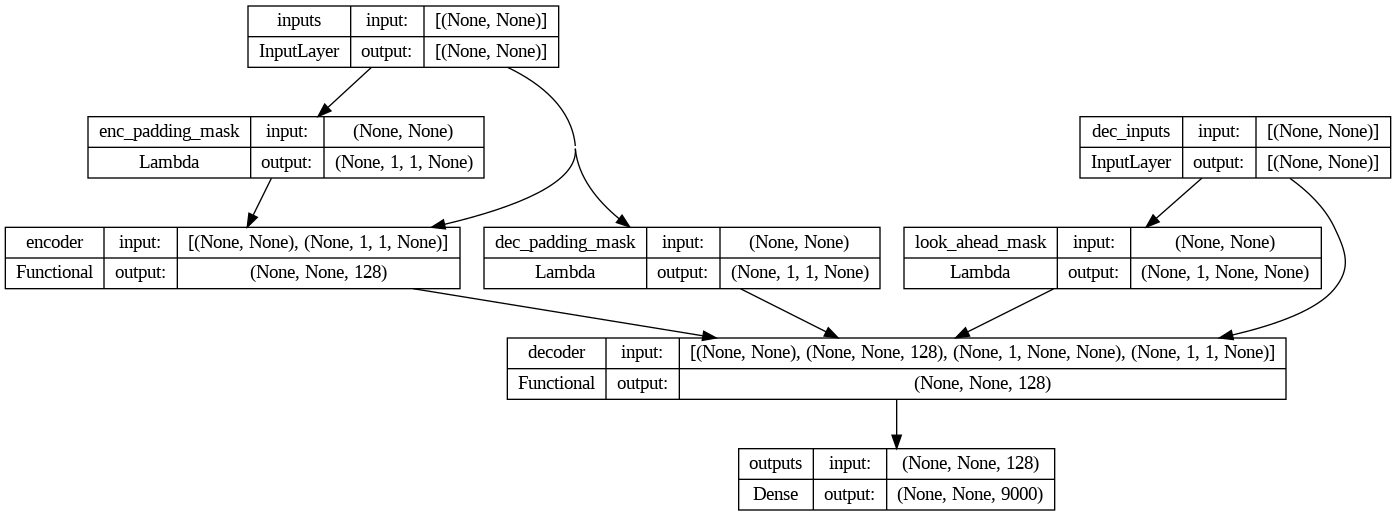

In [43]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [44]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

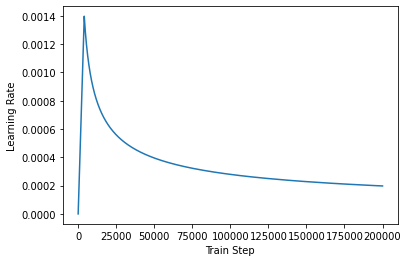

In [46]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Chat

In [47]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 124921


In [48]:
print(train_data.isnull().sum())

A            0
desc         0
tokens       0
clean_tok    0
Q            0
dtype: int64


In [49]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [50]:
len(questions)

124921

In [51]:
print(questions[:5])
print(answers[:5])

['어묵 김밥용김 당면', '현미 찹쌀 호두', '북어포 찹쌀가루', '파스타면', '건표고버섯 오이 당근']
['어묵김말이', '현미호두죽', '북어갈비', '토마토스파게티', '표고버섯탕수']


In [52]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [53]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8074]
종료 토큰 번호 : [8075]
단어 집합의 크기 : 8076


In [54]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [611, 53, 190, 80, 1197, 54, 6674]


In [55]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [611, 53, 190, 80, 1197, 54, 6674]
기존 문장: 모닝빵 새우 상추 토마토 피클 마요네즈 패티


In [56]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

611 ----> 모닝빵 
53 ----> 새우 
190 ----> 상추 
80 ----> 토마토 
1197 ----> 피클 
54 ----> 마요네즈 
6674 ----> 패티


In [57]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [58]:
questions, answers = tokenize_and_filter(questions, answers)

In [59]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (124921, 40)
답변 데이터의 크기(shape) : (124921, 40)


In [61]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8074   56  671  478 8075    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8074  127 2517 8075    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [62]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8076
전체 샘플의 수(Number of samples): 124921


In [63]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [64]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8074  127 2517 8075    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8074  127 2517 8075    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[ 127 2517 8075    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [65]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8076, 256)
(1, 8076, 256)


In [66]:
MAX_LENGTH = 40

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [67]:
EPOCHS = 5

model.fit(dataset, epochs=EPOCHS)

Epoch 1/5
  13/1952 [..............................] - ETA: 1:29:07 - loss: 0.6335 - accuracy: 3.0819e-05

KeyboardInterrupt: ignored

In [55]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [55]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
output = predict('고등어 배추')